In [1]:
#Acelerómetro vs. Giroscopio
#Importación de Librerías

import pandas as pd
import numpy as np
import os
import glob
import time
from multiprocessing import Pool, cpu_count

# Funciones de SciPy y Scikit-learn
from scipy.fft import fft, fftfreq
from scipy.stats import entropy, mode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# --- Funciones de Carga y Extracción de Características ---

def cargar_datos_completos(archivo_sensor, nombre_sensor):
    """Carga y pre-limpia los datos para un sensor específico."""
    lista_datos = []
    if os.path.exists(archivo_sensor):
        print(f"Cargando y procesando archivo: {archivo_sensor}...")
        datos_temporales = pd.read_csv(archivo_sensor, on_bad_lines='skip')
        datos_temporales.dropna(subset=['gt', 'x', 'y', 'z'], inplace=True)
        datos_temporales = datos_temporales[datos_temporales['gt'] != 'null']
        datos_temporales['sensor'] = nombre_sensor
        lista_datos.append(datos_temporales)
    else:
        print(f"Advertencia: No se encontró el archivo '{archivo_sensor}'. Se omitirá.")
        return pd.DataFrame()
        
    if not lista_datos:
        return pd.DataFrame()
    return pd.concat(lista_datos, ignore_index=True)

def calcular_sma(ventana):
    return np.mean(np.abs(ventana['x']) + np.abs(ventana['y']) + np.abs(ventana['z']))

def calcular_entropia_espectral(ventana):
    valor_entropia = 0
    for eje in ['x', 'y', 'z']:
        valores_fft = np.abs(fft(ventana[eje].values))
        potencia_fft = valores_fft**2
        if np.sum(potencia_fft) > 0:
            distribucion_potencia = potencia_fft / np.sum(potencia_fft)
            valor_entropia += entropy(distribucion_potencia)
    return valor_entropia / 3

def extraer_caracteristicas(ventana):
    caracteristicas = {}
    for eje in ['x', 'y', 'z']:
        caracteristicas[f'mean_{eje}'] = ventana[eje].mean()
        caracteristicas[f'std_{eje}'] = ventana[eje].std()
    caracteristicas['corr_xy'] = ventana['x'].corr(ventana['y'])
    caracteristicas['corr_yz'] = ventana['y'].corr(ventana['z'])
    caracteristicas['corr_zx'] = ventana['z'].corr(ventana['x'])
    caracteristicas['sma'] = calcular_sma(ventana)
    caracteristicas['spectral_entropy'] = calcular_entropia_espectral(ventana)
    for eje in ['x', 'y', 'z']:
        caracteristicas[f'jerk_mean_{eje}'] = np.mean(np.diff(ventana[eje], n=1))
    valores_fft = np.abs(fft(ventana['x'].values + ventana['y'].values + ventana['z'].values))
    frecuencias_fft = fftfreq(len(ventana), 1/100)
    indice_frec_dominante = np.argmax(valores_fft[1:]) + 1
    caracteristicas['dominant_freq'] = frecuencias_fft[indice_frec_dominante]
    for eje in ['x', 'y', 'z']:
        caracteristicas[f'energy_{eje}'] = np.mean(ventana[eje]**2)
    return pd.Series(caracteristicas).fillna(0)

def crear_ventanas_y_extraer_caracteristicas(clave_datos, datos_dispositivo_sensor):
    TAMANO_VENTANA = 256
    PASO = 128
    if len(datos_dispositivo_sensor) < TAMANO_VENTANA:
        return pd.DataFrame(), np.array([]) 
    
    lista_caracteristicas, lista_etiquetas = [], []
    for inicio in range(0, len(datos_dispositivo_sensor) - TAMANO_VENTANA, PASO):
        fin = inicio + TAMANO_VENTANA
        ventana = datos_dispositivo_sensor.iloc[inicio:fin]
        caracteristicas = extraer_caracteristicas(ventana)
        caracteristicas['Device'] = clave_datos[0]
        lista_caracteristicas.append(caracteristicas)
        lista_etiquetas.append(mode(ventana['activity_code'], keepdims=True).mode[0])
        
    return pd.DataFrame(lista_caracteristicas), np.array(lista_etiquetas)

def procesar_grupo(grupo):
    """Función 'worker' para la extracción de características."""
    clave, datos = grupo
    df_caracteristicas, array_etiquetas = crear_ventanas_y_extraer_caracteristicas(clave, datos)
    
    if not df_caracteristicas.empty:
        df_caracteristicas['label'] = array_etiquetas
    return df_caracteristicas

print("Funciones de carga y extracción definidas")

Funciones de carga y extracción definidas


In [3]:
# --- Función de Entrenamiento ---

def entrenar_modelo_por_dispositivo(tupla_grupo):
    """
    Función 'worker' para el entrenamiento.
    Toma una tupla (nombre_dispositivo, datos_grupo) y retorna
    (nombre_dispositivo, {'svm': modelo, 'escalador': escalador}).
    """
    nombre_dispositivo, grupo = tupla_grupo
    
    try:
        y_grupo = grupo['label']
        X_grupo = grupo.drop(['label', 'Device'], axis=1)
        
        if X_grupo.empty or y_grupo.empty:
            return (nombre_dispositivo, None)

        escalador = StandardScaler()
        X_grupo_escalado = escalador.fit_transform(X_grupo)
        
        svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
        svm.fit(X_grupo_escalado, y_grupo)
        
        return (nombre_dispositivo, {'svm': svm, 'escalador': escalador})
    
    except Exception as e:
        print(f"Error entrenando {nombre_dispositivo}: {e}")
        return (nombre_dispositivo, None)

print("Función de entrenamiento definida.")

Función de entrenamiento definida.


In [4]:
# --- Configuración de los Experimentos ---

# Lista de sensores a probar
SENSORES_A_PROBAR = {
    'Accelerometer': 'Phones_accelerometer.csv',
    'Gyroscope': 'Phones_gyroscope.csv'
}

# Lista de núcleos a probar.
MAXIMOS_NUCLEOS = cpu_count()
CONTEO_NUCLEOS_A_PROBAR = [2, 4, 8, 12, 16, 20]
# Nos aseguramos de no probar más núcleos de los que tienes
CONTEO_NUCLEOS_A_PROBAR = [n for n in CONTEO_NUCLEOS_A_PROBAR if n <= MAXIMOS_NUCLEOS]

print(f"Se probarán {len(SENSORES_A_PROBAR)} sensores.")
print(f"Máximo de núcleos detectados: {MAXIMOS_NUCLEOS}")
print(f"Se probará N=1 (Secuencial) y N={CONTEO_NUCLEOS_A_PROBAR} (Paralelo)")

# Diccionarios para guardar todos nuestros resultados
todos_los_resultados = {}
datos_evaluacion_modelos = {}

Se probarán 2 sensores.
Máximo de núcleos detectados: 20
Se probará N=1 (Secuencial) y N=[2, 4, 8, 12, 16, 20] (Paralelo)


In [5]:
# --- Bucle Principal de Análisis ---
# Esto ejecutará todo el proceso para cada sensor.

for nombre_sensor, archivo_sensor in SENSORES_A_PROBAR.items():
    print(f"\n" + "="*80)
    print(f"Iniciando Análisis para: {nombre_sensor} ({archivo_sensor})")
    print("="*80)
    
    # --- 1. Carga y Preparación de Datos (para este sensor) ---
    datos = cargar_datos_completos(archivo_sensor, nombre_sensor)
    if datos.empty:
        print(f"No se pudieron cargar datos para {nombre_sensor}. Saltando...")
        continue

    # LabelEncoder específico para este dataset
    codificador_etiquetas = LabelEncoder()
    datos['activity_code'] = codificador_etiquetas.fit_transform(datos['gt'])
    datos[['x', 'y', 'z']] = datos[['x', 'y', 'z']].astype(np.float64)
    
    # Preparar los datos para map/pool.map
    datos_agrupados = list(datos.groupby(['Device', 'sensor']))
    
    print(f"Datos cargados para {nombre_sensor}. {len(datos_agrupados)} grupos de dispositivos.")

    # --- 2. Experimento SECUENCIAL (N=1) ---
    print("\n--- (N=1) Iniciando Experimento SECUENCIAL (Baseline) ---")
    
    # 2.1 Extracción de Features Secuencial
    print("  (N=1) Extrayendo características...")
    inicio_feat_sec = time.time()
    lista_df_resultados_sec = list(map(procesar_grupo, datos_agrupados))
    fin_feat_sec = time.time()
    Ts_caracteristicas = fin_feat_sec - inicio_feat_sec
    print(f"  (N=1) Extracción de features: {Ts_caracteristicas:.4f} s")

    # 2.2 Preparación de Entrenamiento
    df_todas_caracteristicas_sec = pd.concat(lista_df_resultados_sec, ignore_index=True)
    y_sec = df_todas_caracteristicas_sec['label']
    X_sec = df_todas_caracteristicas_sec.drop('label', axis=1)
    X_entrenamiento_sec, X_prueba_sec, y_entrenamiento_sec, y_prueba_sec = train_test_split(
        X_sec, y_sec, test_size=0.2, random_state=42, stratify=y_sec
    )
    datos_entrenamiento_sec = pd.concat([X_entrenamiento_sec, y_entrenamiento_sec], axis=1)
    datos_entrenamiento_agrupados_sec = list(datos_entrenamiento_sec.groupby('Device'))

    # 2.3 Entrenamiento Secuencial
    print("  (N=1) Entrenando modelos...")
    inicio_entren_sec = time.time()
    resultados_sec = list(map(entrenar_modelo_por_dispositivo, datos_entrenamiento_agrupados_sec))
    fin_entren_sec = time.time()
    Ts_entrenamiento = fin_entren_sec - inicio_entren_sec
    print(f"  (N=1) Entrenamiento: {Ts_entrenamiento:.4f} s")

    # 2.4 Resultados Secuenciales (Baseline)
    Ts_total = Ts_caracteristicas + Ts_entrenamiento
    todos_los_resultados[nombre_sensor] = [{
        'N': 1,
        'Tiempo (s)': Ts_total,
        'Aceleracion': 1.0,
        'Eficiencia': 1.0,
        'T_Features (s)': Ts_caracteristicas,
        'T_Training (s)': Ts_entrenamiento
    }]
    print(f"--- (N=1) TIEMPO TOTAL SECUENCIAL: {Ts_total:.4f} s ---")

    # 2.5 Guardar modelo para evaluación
    datos_evaluacion_modelos[nombre_sensor] = (
        dict(resultados_sec), 
        X_prueba_sec.drop('Device', axis=1), 
        y_prueba_sec, 
        codificador_etiquetas.classes_
    )
    
    # --- 3. Experimentos PARALELOS (N > 1) ---
    for N in CONTEO_NUCLEOS_A_PROBAR:
        print(f"\n--- (N={N}) Iniciando Experimento PARALELO ---")
        
        # 3.1 Extracción de Features Paralela
        print(f"  (N={N}) Extrayendo características...")
        inicio_feat_par = time.time()
        with Pool(N) as pool:
            lista_df_resultados_par = pool.map(procesar_grupo, datos_agrupados)
        fin_feat_par = time.time()
        Tp_caracteristicas = fin_feat_par - inicio_feat_par
        print(f"  (N={N}) Extracción de features: {Tp_caracteristicas:.4f} s")

        # 3.2 Entrenamiento Paralelo
        print(f"  (N={N}) Entrenando modelos...")
        inicio_entren_par = time.time()
        with Pool(N) as pool:
            resultados_par = pool.map(entrenar_modelo_por_dispositivo, datos_entrenamiento_agrupados_sec)
        fin_entren_par = time.time()
        Tp_entrenamiento = fin_entren_par - inicio_entren_par
        print(f"  (N={N}) Entrenamiento: {Tp_entrenamiento:.4f} s")
        
        # 3.3 Resultados Paralelos
        Tp_total = Tp_caracteristicas + Tp_entrenamiento
        aceleracion = Ts_total / Tp_total
        eficiencia = aceleracion / N
        
        todos_los_resultados[nombre_sensor].append({
            'N': N,
            'Tiempo (s)': Tp_total,
            'Aceleracion': aceleracion,
            'Eficiencia': eficiencia,
            'T_Features (s)': Tp_caracteristicas,
            'T_Training (s)': Tp_entrenamiento
        })
        print(f"--- (N={N}) TIEMPO TOTAL PARALELO: {Tp_total:.4f} s ---")
        print(f"--- (N={N}) Aceleración: {aceleracion:.2f}x, Eficiencia: {eficiencia:.2%} ---")

    print(f"\n" + "="*80)
    print(f"Análisis para {nombre_sensor} completado.")
    print("="*80)

print("\n\nTODOS LOS EXPERIMENTOS HAN FINALIZADO.")


Iniciando Análisis para: Accelerometer (Phones_accelerometer.csv)
Cargando y procesando archivo: Phones_accelerometer.csv...
Datos cargados para Accelerometer. 8 grupos de dispositivos.

--- (N=1) Iniciando Experimento SECUENCIAL (Baseline) ---
  (N=1) Extrayendo características...
  (N=1) Extracción de features: 128.4963 s
  (N=1) Entrenando modelos...
  (N=1) Entrenamiento: 3.8271 s
--- (N=1) TIEMPO TOTAL SECUENCIAL: 132.3234 s ---

--- (N=2) Iniciando Experimento PARALELO ---
  (N=2) Extrayendo características...
  (N=2) Extracción de features: 72.4450 s
  (N=2) Entrenando modelos...
  (N=2) Entrenamiento: 2.1191 s
--- (N=2) TIEMPO TOTAL PARALELO: 74.5641 s ---
--- (N=2) Aceleración: 1.77x, Eficiencia: 88.73% ---

--- (N=4) Iniciando Experimento PARALELO ---
  (N=4) Extrayendo características...
  (N=4) Extracción de features: 42.6063 s
  (N=4) Entrenando modelos...
  (N=4) Entrenamiento: 1.5384 s
--- (N=4) TIEMPO TOTAL PARALELO: 44.1447 s ---
--- (N=4) Aceleración: 3.00x, Eficienc


################################################################################
Resultados de Rendimiento para: Accelerometer
################################################################################
Módulo 'tabulate' no encontrado. Imprimiendo DataFrame estándar.
    Tiempo (s)  Aceleracion  Eficiencia  T_Features (s)  T_Training (s)
N                                                                      
1   132.323393     1.000000    1.000000      128.496275        3.827118
2    74.564075     1.774627    0.887313       72.445009        2.119066
4    44.144722     2.997491    0.749373       42.606306        1.538416
8    41.070019     3.221898    0.402737       39.377364        1.692655
12   41.498650     3.188619    0.265718       39.783135        1.715515
16   43.096836     3.070374    0.191898       41.156300        1.940537
20   42.974040     3.079147    0.153957       40.995810        1.978230


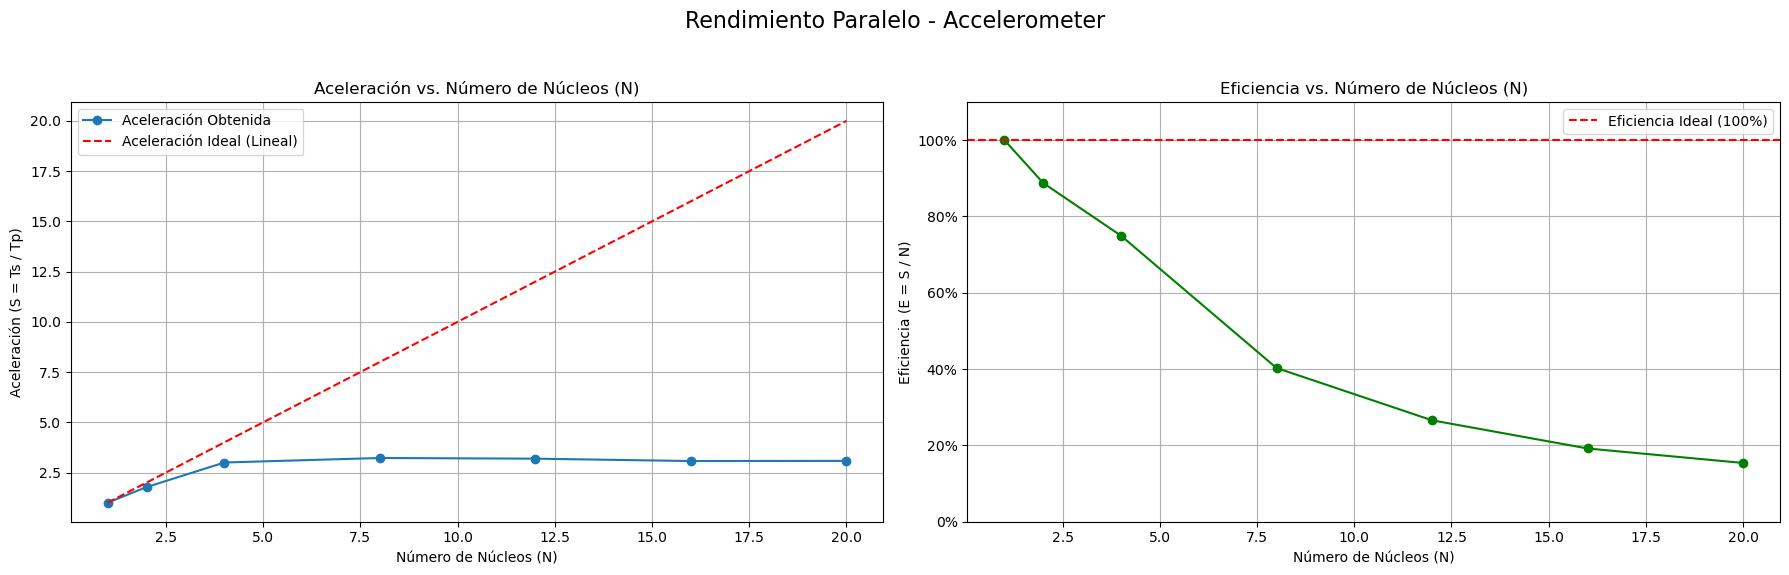


################################################################################
Resultados de Rendimiento para: Gyroscope
################################################################################
Módulo 'tabulate' no encontrado. Imprimiendo DataFrame estándar.
    Tiempo (s)  Aceleracion  Eficiencia  T_Features (s)  T_Training (s)
N                                                                      
1   145.464155     1.000000    1.000000      138.498398        6.965758
2    80.996845     1.795924    0.897962       77.184136        3.812709
4    53.776288     2.704987    0.676247       50.711329        3.064958
8    47.934999     3.034613    0.379327       45.007926        2.927073
12   46.397258     3.135189    0.261266       43.946697        2.450561
16   43.948702     3.309862    0.206866       41.295311        2.653391
20   43.722867     3.326958    0.166348       41.008060        2.714807


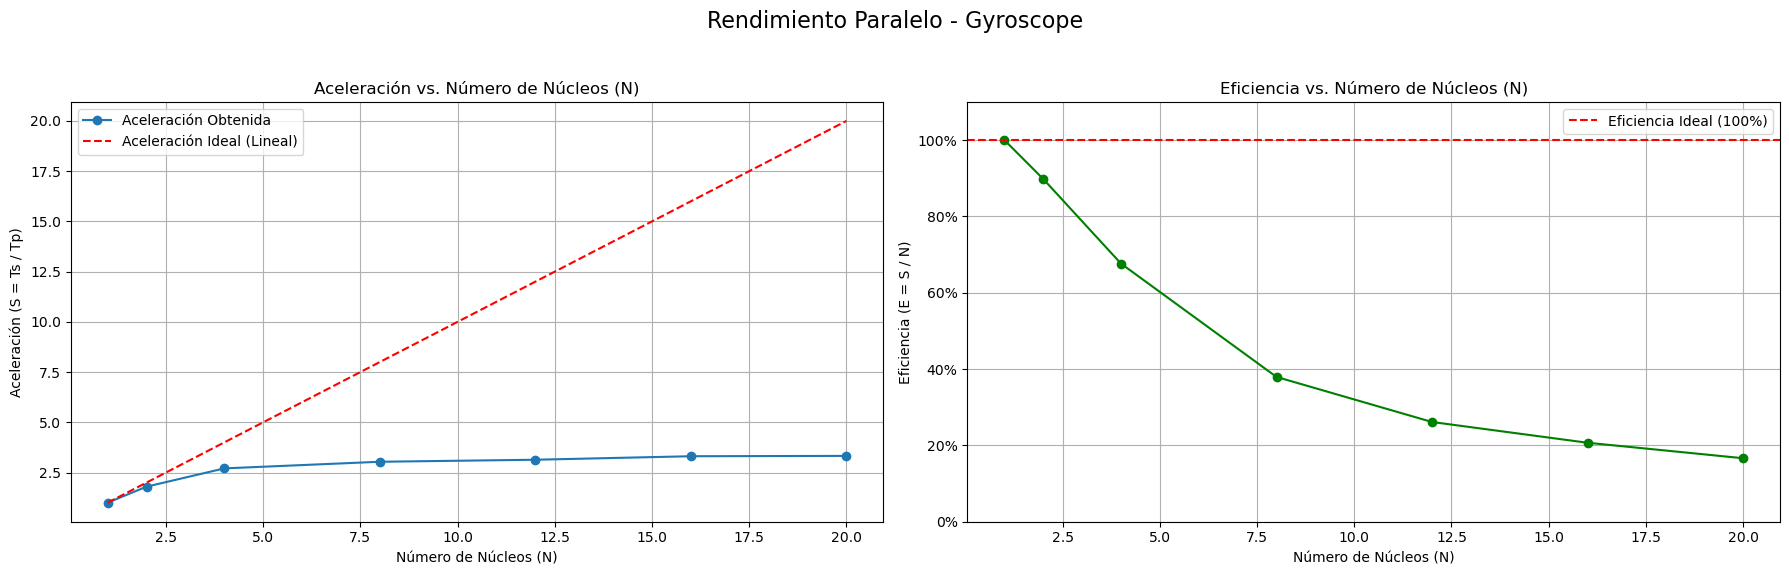

In [6]:
# --- Visualización de Métricas de Rendimiento ---

for nombre_sensor, resultados in todos_los_resultados.items():
    print(f"\n" + "#"*80)
    print(f"Resultados de Rendimiento para: {nombre_sensor}")
    print("#"*80)
    
    # 1. Mostrar Tabla de Resultados
    df_resultados = pd.DataFrame(resultados).set_index('N')
    # Usamos .to_markdown() que causó el error anterior
    try:
        print(df_resultados.to_markdown(floatfmt=".4f"))
    except ImportError:
        print("Módulo 'tabulate' no encontrado. Imprimiendo DataFrame estándar.")
        print(df_resultados)
    
    # 2. Crear Gráficas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Rendimiento Paralelo - {nombre_sensor}', fontsize=16)
    
    # Gráfica de Aceleración (Speedup)
    ax1.plot(df_resultados.index, df_resultados['Aceleracion'], 'o-', label='Aceleración Obtenida')
    ax1.plot(df_resultados.index, df_resultados.index, 'r--', label='Aceleración Ideal (Lineal)')
    ax1.set_title('Aceleración vs. Número de Núcleos (N)')
    ax1.set_xlabel('Número de Núcleos (N)')
    ax1.set_ylabel('Aceleración (S = Ts / Tp)')
    ax1.legend()
    ax1.grid(True)
    
    # Gráfica de Eficiencia
    ax2.plot(df_resultados.index, df_resultados['Eficiencia'], 'o-g')
    ax2.axhline(y=1.0, color='r', linestyle='--', label='Eficiencia Ideal (100%)')
    ax2.set_title('Eficiencia vs. Número de Núcleos (N)')
    ax2.set_xlabel('Número de Núcleos (N)')
    ax2.set_ylabel('Eficiencia (E = S / N)')
    ax2.set_ylim(0, 1.1)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


################################################################################
Evaluación de la Calidad de los Modelos
################################################################################

--- Reporte de Clasificación para: Accelerometer ---

Precisión (Accuracy) del modelo: 85.78%

Reporte de Clasificación:
              precision    recall  f1-score   support

        bike       0.90      0.96      0.93      2882
         sit       0.90      0.92      0.91      3113
  stairsdown       0.76      0.81      0.78      2526
    stairsup       0.80      0.76      0.78      2783
       stand       0.91      0.93      0.92      2892
        walk       0.86      0.77      0.81      3426

    accuracy                           0.86     17622
   macro avg       0.85      0.86      0.86     17622
weighted avg       0.86      0.86      0.86     17622



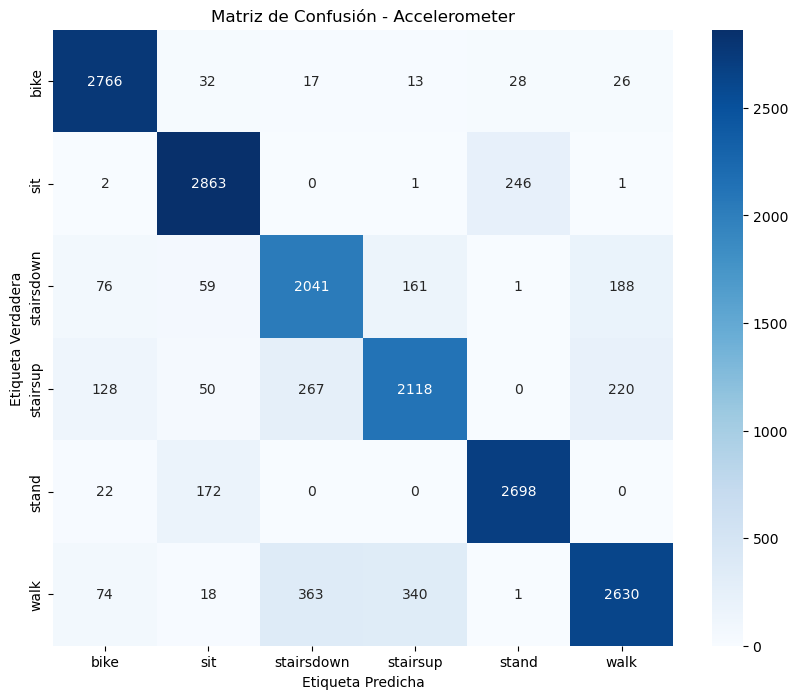


--- Reporte de Clasificación para: Gyroscope ---

Precisión (Accuracy) del modelo: 85.02%

Reporte de Clasificación:
              precision    recall  f1-score   support

        bike       0.90      0.91      0.91      2986
         sit       0.79      0.82      0.80      3467
  stairsdown       0.81      0.86      0.83      2615
    stairsup       0.91      0.88      0.90      2944
       stand       0.79      0.75      0.77      3162
        walk       0.90      0.88      0.89      3673

    accuracy                           0.85     18847
   macro avg       0.85      0.85      0.85     18847
weighted avg       0.85      0.85      0.85     18847



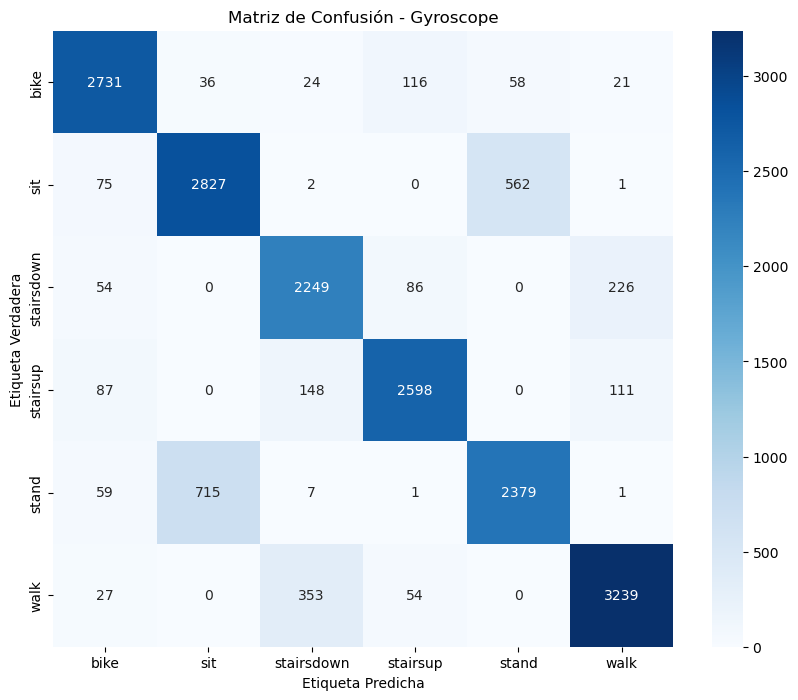

In [7]:
# --- Evaluación de Modelos (Usando los modelos del N=1) ---

print("\n" + "#"*80)
print("Evaluación de la Calidad de los Modelos")
print("#"*80)

for nombre_sensor, (modelos, X_prueba, y_prueba, clases) in datos_evaluacion_modelos.items():
    print(f"\n--- Reporte de Clasificación para: {nombre_sensor} ---")
    
    # Realizar predicciones
    todas_las_predicciones = []
    for nombre_dispositivo, datos_modelo in modelos.items():
        if datos_modelo is None:
            continue
            
        svm = datos_modelo['svm']
        escalador = datos_modelo['escalador']
        
        X_prueba_escalado = escalador.transform(X_prueba)
        predicciones = svm.predict(X_prueba_escalado)
        todas_las_predicciones.append(predicciones)
    
    # Votación mayoritaria
    if not todas_las_predicciones:
        print(f"No se generaron predicciones para {nombre_sensor}.")
        continue
        
    matriz_predicciones = np.array(todas_las_predicciones).T
    y_prediccion_votada, _ = mode(matriz_predicciones, axis=1, keepdims=False)

    # Mostrar Métricas de Clasificación
    precision = accuracy_score(y_prueba, y_prediccion_votada)
    reporte = classification_report(y_prueba, y_prediccion_votada, target_names=clases)
    
    print(f"\nPrecisión (Accuracy) del modelo: {precision * 100:.2f}%")
    print("\nReporte de Clasificación:")
    print(reporte)

    # Mostrar Matriz de Confusión
    matriz_confusion = confusion_matrix(y_prueba, y_prediccion_votada)
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', 
                xticklabels=clases, yticklabels=clases)
    plt.title(f'Matriz de Confusión - {nombre_sensor}')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()